# Advanced RNN (recurrent neural network) models

In this notebook, we illustrate how to use RNN models to analyse time series (longitudinal) data.
The specific type of statistical problem here is **forecasting**.


## Loading libraries and setting the random seed

First of all, we load some necessary libraries; then we setup the random seed to ensure reproducibility of results. Since tensorflow uses an internal random generator we need to fix both the general seed (via numpy `seed()`) and tensorflow seed (via `set_seet()`)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader

from pandas_datareader import data

  # Set the seed using keras.utils.set_random_seed. This will set:
  # 1) `numpy` seed
  # 2) `tensorflow` random seed
  # 3) `python` random seed
tf.keras.utils.set_random_seed(10)

  # This will make TensorFlow ops as deterministic as possible, but it will
  # affect the overall performance, so it's not enabled by default.
  # `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

## A RNN model to analyse climate data

RNN are a type of deep learning architecture suited to work with **longitudinal data**, e.g. time series data.

Time series data include many types of data, like:

- economic indicators (e.g. *quarterly GDP*, *monthly inflation*)
- patient health evolution metrics (e.g.*ECG data*)

Time series data include a fundamental **time component**, and are often used in **forecasting problems**.

Here we use maximum daily temperatures in Melbourne (Australia), over the period 1981 - 1990, as an example to train a recurrent neural network (RNN) model.

In [ ]:
## getting the data
DATAURL = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-max-temperatures.csv'
df = pd.read_csv(DATAURL)
print("N. of row in dataframe: ",len(df))
df.head()

N. of row in dataframe:  3650


,Date,Temperature
0,1981-01-01,38.1
1,1981-01-02,32.4
2,1981-01-03,34.5
3,1981-01-04,20.7
4,1981-01-05,21.5


We will use Melbourne maximum daily temperature (`Temperature`) in a forecasting problem

First, we split data into train/test: we use the last year as test, and all remaining observations as training set.

In [ ]:
temperature = df['Temperature']
n = len(temperature) - 365 # training set
print('The size of the training data is', n)

The size of the training data is 3285


Let's have a look at the distribution of the training and testing data:

<Axes: >

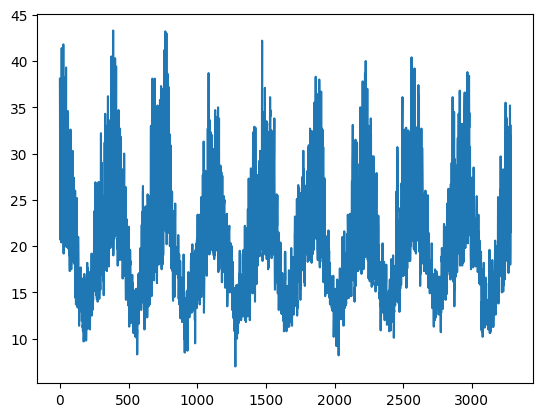

In [ ]:
df['Temperature'][:n].plot()

<Axes: >

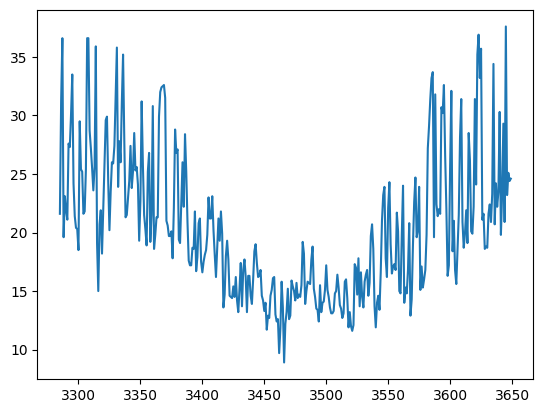

In [ ]:
df['Temperature'][n:].plot()

In [ ]:
train = list(temperature)[:n] #first n temperatures
test = list(temperature)[n:] #remaining temperatures

#### Data representation

We have two series of data (temperatures), for training and for testing.
For training, we have therefore one data series, and we need to use an appropriate representation for the feature data to be used for prediction (forecasting).

A common possibility is to use preceding values in the series to predict the next one(s): for instance, a sliding-window appraoch can be used (see figure below)

<img src="https://miro.medium.com/max/700/1*murkc0tNsvgdQDVgKqSdfQ.png">

In [ ]:
## prepare the training data
windowSize, X_train, y_train = 10, [], [] #initialize lists and set window size
for index in range(len(train)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    curr_value = train[index:index+windowSize]
    #print(index)
    #print(curr_value)
    X_train.append(curr_value) #append the range from index to index+windowSize to x
    y_train.append(train[index+windowSize]) #append the next value to the y

X_train,y_train = np.array(X_train), np.array(y_train) #convert to numpy array
X_train = X_train.reshape((len(X_train), windowSize, 1)) #reshape X_train to proper 3-d array

print(y_train.shape)
print(X_train.shape)

(3275,)
(3275, 10, 1)


In [ ]:
## prepare the test data
windowSize, X_test, y_test = 10, [], [] #initialize lists and set window size
for index in range(len(test)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    X_test.append(test[index:index+windowSize]) #append the range from index to index+windowSize to x
    y_test.append(test[index+windowSize]) #append the next value to the y

X_test,y_test = np.array(X_test), np.array(y_test) #convert to numpy array
X_test = X_test.reshape((len(X_test), windowSize, 1)) #reshape X_train to proper 3-d array

print(y_test.shape)
print(X_test.shape)

(355,)
(355, 10, 1)


### Simple RNN

Let's start with a simple RNN model:
- one RNN layer (12 units)
- one dense layer (output layer: one number per timepoint, regression problem)

In [ ]:
from keras import Sequential
from keras.layers import SimpleRNN, Dense, Input

import math
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
 input_shape = (windowSize,1)
 print(input_shape)

In [ ]:
model = Sequential() #initializing sequential model, layers can be added sequentially with model.add
model.add(Input(input_shape))
model.add(SimpleRNN(12)) #simple recurrent layer, 10 neurons & process 10x1 sequences
model.add(Dense(1,activation='linear')) #linear output because this is a regression problem
model.summary()

- 12 units
- recurrent weights (states/activations are fed recursively): matrix $\mathbf{W_{aa}}(u,u)$
- input weights: n. units x n. features (here the number of features is 1: one sequence of previous values). For the blood pressure example, this would be 2 (diastolic and sistolic pressure values)
- one bias term per unit

$$
168 = 12 \text{ units} \cdot 12 \text{ units} + 12 \text{ units} \cdot 1 \text{ feature} + 12 \text{ bias terms}
$$

In [ ]:
## let's fit the model
loss_function = 'mse'
optimizer_algorithm = 'Adam'
metrics_list = ['mae',tf.keras.metrics.RootMeanSquaredError()]
n_epochs = 20

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=metrics_list)
history = model.fit(X_train,y_train,epochs=n_epochs, verbose=1, validation_data=(X_test, y_test))

In [ ]:
print(history.history.keys())
plt.plot(history.history['mae'])

In [ ]:
## let's look at predictions
predictions = model.predict(X_test)
nrow = len(y_test)
temp = y_test.reshape(nrow,1)

## MAPE
ptc_err = 100*(abs(predictions - temp)/abs(temp))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (predictions - y_test)**2
rmse = math.sqrt(sqerr.mean())

## CORRELATION


print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " degrees")

In [ ]:
y_pred = pd.Series(predictions[:,0])
y = pd.Series(y_test.astype(float))

## CORRELATION
print(y_pred.corr(y))

In [ ]:
res = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()
print(res)
res[['y_test','y_pred']].plot()

Why is it so? We see that predictions fail to capture the highest temperatures at both extremes (left and right, australian summer).

**QUESTION: what is going on?**

### Data preprocessing

We may want to consider to normalise the data, that now are on the celsius degree scale.

First, we calculate the average and the standard deviation on the training data:

In [ ]:
avg = df['Temperature'][:n].mean()
dev_std = df['Temperature'][:n].std()

Now, we can normalize (standardize) the data (both training and test):

In [ ]:
train = (train-avg)/dev_std
test = (test-avg)/dev_std

In [ ]:
train

In [ ]:
plt.plot(train)

In [ ]:
plt.plot(test)

Now we need to recreate the sliding-window representation (again, both for the training and the test data):

In [ ]:
## prepare the training data
windowSize, X_train, y_train = 10, [], [] #initialize lists and set window size
for index in range(len(train)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    X_train.append(train[index:index+windowSize]) #append the range from index to index+windowSize to x
    y_train.append(train[index+windowSize]) #append the next value to the y

X_train,y_train = np.array(X_train), np.array(y_train) #convert to numpy array
X_train = X_train.reshape((len(X_train), windowSize, 1)) #reshape X_train to proper 3-d array

print(y_train.shape)
print(X_train.shape)

In [ ]:
## prepare the test data
windowSize, X_test, y_test = 10, [], [] #initialize lists and set window size
for index in range(len(test)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    X_test.append(test[index:index+windowSize]) #append the range from index to index+windowSize to x
    y_test.append(test[index+windowSize]) #append the next value to the y

X_test,y_test = np.array(X_test), np.array(y_test) #convert to numpy array
X_test = X_test.reshape((len(X_test), windowSize, 1)) #reshape X_train to proper 3-d array

print(y_test.shape)
print(X_test.shape)

Let's fit again the RNN model:

In [ ]:
model = Sequential()
model.add(Input(input_shape)) #initializing sequential model, layers can be added sequentially with model.add
model.add(SimpleRNN(12)) #simple recurrent layer, 10 neurons & process 10x1 sequences
model.add(Dense(1,activation='linear')) #linear output because this is a regression problem
model.summary()

In [ ]:
## let's fit the model
loss_function = 'mse'
optimizer_algorithm = 'Adam'
metrics_list = ['mae',tf.keras.metrics.RootMeanSquaredError()]
n_epochs = 20

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=metrics_list)
history = model.fit(X_train,y_train,epochs=n_epochs, verbose=1, validation_data=(X_test, y_test))

In [ ]:
plt.plot(history.history['mae'])

And now, the predictions: first, on the standardized scale

In [ ]:
## let's look at predictions
predictions = model.predict(X_test)
nrow = len(y_test)
temp = y_test.reshape(nrow,1)

## MAPE
ptc_err = 100*(abs(predictions - temp)/abs(temp))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (predictions - y_test)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " dev std")

We see that the shape of the test data is now better captured:

In [ ]:
y_pred = pd.Series(predictions[:,0])
y = pd.Series(y_test.astype(float))

## CORRELATION
print(y_pred.corr(y))

In [ ]:
df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

#### Backtransform the data

Let's put our data back on the Celsius degrees scale:

$$
x_{degrees} = \sigma \cdot x_{std} + μ
$$

In [ ]:
y_pred = pd.Series(predictions[:,0])
y_pred = (y_pred * dev_std) + avg
y = pd.Series(y_test.astype(float))
y = (y * dev_std) + avg

df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

In [ ]:
## MAPE
ptc_err = 100*(abs(y_pred - y)/abs(y))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (y_pred - y)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " degrees")